In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Input, GRU, Dropout, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.saving import load_model

from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

from pathlib import Path

In [ ]:
def create_model(latent_dim):
    encoder_inputs = Input(shape=(10, 70))
    encoder = GRU(latent_dim, return_state=True)
    encoder_outputs, state_h = encoder(encoder_inputs)

    decoder_inputs = Input(shape=(None, 70))
    decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
    decoder_dense = Dense(70, activation="softmax")

    all_outputs = []
    inputs = decoder_inputs
    for _ in range(71):
        outputs, state_h = decoder_gru(inputs, initial_state=state_h)
        outputs = decoder_dense(outputs)
        all_outputs.append(outputs)
        inputs = outputs
    print(all_outputs[0])

    decoder_outputs = Concatenate(axis=1)(all_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model


In [ ]:
def read_patch(patch_file):
    df = pd.read_csv(patch_file)
    df = df.drop("Time", axis=1)
    sterile_male_col = df.pop("Sterile Male Adult")
    return df.values, sterile_male_col.values.reshape(-1, 1)

def read_simulation(simulation_folder):
    path2csv = Path(simulation_folder)
    nb_csvfile = len(list(path2csv.glob("*.csv")))
    csvlist = [f"{simulation_folder}/{i:0{len(str(nb_csvfile-1))}}.csv" for i in range(nb_csvfile)]
    wild_pop_list, sterile_male_list = zip(*[read_patch(patch_file) for patch_file in csvlist])
    wild_pop = np.concatenate(wild_pop_list, axis=1)
    sterile_male = np.concatenate(sterile_male_list, axis=1)
    return np.concatenate((wild_pop, sterile_male), axis=1), sterile_male.shape[1]

def process_seq2seq(simulation_folder, lookback):
    data, nb_sterile = read_simulation(simulation_folder)
    return data[:lookback, :data.shape[1]-nb_sterile], data[lookback:, :data.shape[1]-nb_sterile]


def read_dataset_seq2seq(dataset, lookback):
    X_list, Y_list = zip(*[process_seq2seq(folder.path, lookback) for folder in os.scandir(dataset)])
    return np.array(X_list), np.array(Y_list)

In [ ]:
DATASET_NAME = "UN"
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/UN"
LOOKBACK = 10
X, Y = read_dataset_seq2seq(f"{DATASET_PATH}/train", LOOKBACK)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.concatenate([X.reshape(-1, 70), Y.reshape(-1, 70)], axis=0))
for i in range(X.shape[0]):
    X[i, :, :] = scaler.transform(X[i, :, :])
for i in range(Y.shape[0]):
    Y[i, :, :] = scaler.transform(Y[i, :, :])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = create_model(200)
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit([X, np.zeros((X.shape[0], 1, 70))], Y, epochs=50, batch_size=25)


<KerasTensor shape=(None, None, 70), dtype=float32, sparse=False, name=keras_tensor_1601>
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 128s 206ms/step - loss: 0.3898
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.3895
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.3897
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - loss: 0.3892
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - loss: 0.3890
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.3872
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.3846
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.3840
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.3831
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.3834
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.3830
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.3829
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.3828
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 

In [ ]:
plot_loss(model_lookback)
print(min(model_lookback.history.history["val_loss"]))

NameError: name 'plot_loss' is not defined

In [ ]:
real, pred = moving_predict(X_trans, model_lookback, scaler, LOOKBACK, 80)
real = scaler.transform(real)
pred = scaler.transform(pred)
print(np.mean(np.square(real-pred)))

0.00356805325090643


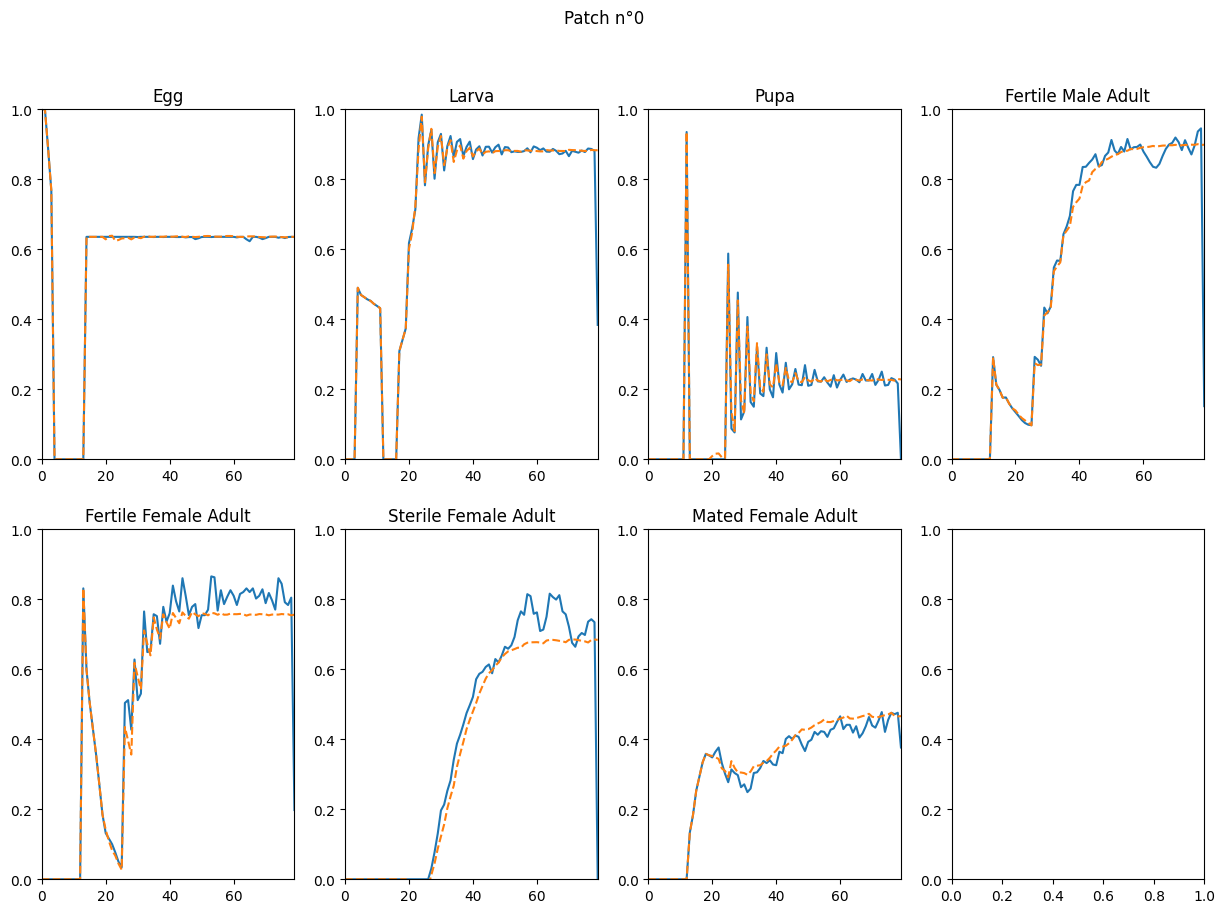

In [ ]:
draw_prediction(real, pred, 0)